In [16]:
import xarray as xr
import numpy as np
import warnings
import matplotlib.pyplot as plt
import pandas as pd
warnings.filterwarnings('ignore')
plt.style.use('default')
import os
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box, mapping
import geopandas as gpd
from matplotlib import cm
import texttable
from xclim import ensembles
import global_land_mask
import logging
from CMIP6_ridgeplot import CMIP6_ridgeplot
import CMIP6_area_calculations
import matplotlib.dates as mdates

logging.getLogger('xclim').setLevel('ERROR')
logging.getLogger('root').setLevel('ERROR')
sns.set(font_scale=1.5, style="whitegrid")

In [17]:
def convert_to_180(ds):
 #   ds=ds.assign_coords(lat=ds.y)
    return (ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))).sortby('lon')

def convert_time(ds):
    if not ds.indexes["time"].dtype in ["datetime64[ns]"]:

        time_objects = ds.indexes['time'].to_datetimeindex() 
        ds=ds.assign_coords({"time": time_objects})                   
        ds = xr.decode_cf(ds)
        
    return ds

def create_land_ocean_mask(cmip6_grid: xr.Dataset) -> xr.DataArray:
    print("[create_land_ocean_mask] Running create_land_ocean_mask")
    lon = cmip6_grid.lon.values
    lat = cmip6_grid.lat.values
    lon_180 = xr.where(lon > 180, lon - 360, lon)
    lon_grid, lat_grid = np.meshgrid(lon_180, lat)

    mask_data = global_land_mask.globe.is_ocean(lat_grid, lon_grid).astype(int)
    #  mask_data[np.isnan(mask_data)] = np.nan

    return xr.DataArray(mask_data, coords={'lat': lat, 'lon': lon},
                        dims=['lat', 'lon'])

def resample_to_monthly(ds:xr.Dataset, var_name):
    ds = xr.where(((ds < 1.e-20) | (ds > 1e20)), np.nan, ds)
    if var_name=="tos_mean":
        ds=ds.assign(lon=ds.lon[0,:].values)
        ds=ds.assign(lat=ds.lat[:,0].values)
        ds=ds.rename({"x":"lon","y":"lat"})
        print(ds)
    ds = convert_to_180(ds)
   # ds = ds.sel(time=slice(start_time,end_time))
    ds_lme = convert_time(ds)
    # Add land mask
    ds_lme["mask"] = create_land_ocean_mask(ds_lme)

    ds_lme = ds_lme.where(ds_lme.mask == 1)
    # Input data contains 4 timesteps per mid-day of each month.
    ds_lme = ds_lme.resample(time="M").mean()

  #  ds_lme = ds_lme.resample(time="1W").reduce(np.mean)
   # ds_lme = get_data_within_LME(ds_lme, LME)
    return ds_lme

def get_area_averaged_ds(fname_perc, fname_stats, fname_tos, scenario, var_name, LME):

    var_name_mean = f"{var_name}_min"
    var_name_std = f"{var_name}_stdev"
    var_name_tos = f"tos_mean"

    if os.path.exists(fname_stats) and os.path.exists(fname_perc) and os.path.exists(fname_tos):
        ds_perc = xr.open_dataset(fname_perc).isel(percentiles=0)
        ds_tos = xr.open_dataset(fname_tos)

      # ds_perc = ds_perc.sel(time=ds_perc.time.dt.hour == 12)

        ds_perc = resample_to_monthly(ds_perc, var_name)
        ds_perc = get_data_within_LME(ds_perc, LME)

        ds_tos = resample_to_monthly(ds_tos, var_name_tos)
        ds_tos = get_data_within_LME(ds_tos, LME)


        fname=f"Months_per_year_with_minimum_light_{LME}_{scenario}.nc"
        fname_tos=f"Months_per_year_with_minimum_light_tos_{LME}_{scenario}.nc"
        if os.path.exists(fname): os.remove(fname)
        if os.path.exists(fname_tos): os.remove(fname_tos)
        print("Saving number of months per year where  on average min light is reached")
        ds_perc.to_netcdf(fname)
        ds_tos.to_netcdf(fname_tos)

In [18]:
def get_LME_records():
    lme_file='../oceanography/Shapefiles/LME66/LMEs66.shp'
    return gpd.read_file(lme_file)

def get_data_within_LME(ds,LME):
    print("Working on LME: {}".format(LME))

    # Extract the polygon defining the boundaries of the LME
    shdf = get_LME_records()
    shdf_sel = shdf[ shdf['LME_NAME']==LME ]

    # Rioxarray requires x and y dimensions - we convert these back to lon and lat later.
    # We also add the projection (lat-lon) so that rioxarray can do the clipping of the data according to the
    # shapefile.
    tos=ds.rename({'lon': 'x','lat': 'y'})
    tos=tos.rio.write_crs(4326)

    # Clip the data within the LME. We have to convert the polygon geometry to a geodataframe using
    # `shapely.geometry`. The clipping of data within the polygon is done using rioxarray.clip function
    clipped = tos.rio.clip(geometries=shdf_sel.geometry.apply(mapping), crs=tos.rio.crs)
    clipped=clipped.rename({'x': 'lon','y': 'lat'})

    return clipped

In [19]:
scenarios = ["ssp245", "ssp585"]
member_range = 12

period = "1979-01-01-2099-12-16"
start_time = "1979-01-01"
end_time = "2099-12-16"

models = ["ensemble"]
ds_var_names = ["par"]

write_stats_to_file = False
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=1.5)

LMES = ['Barents Sea', 'Northern Bering - Chukchi Seas']
#LMES = ['Barents Sea']

for var_name in ds_var_names:
    for LME in LMES:
        # We loop over all of the scenarios, ensemble_ids, and models to create a
        # list of dataframes that we eventually concatenate together and plot
        for scenario in scenarios:

            fname_perc = f"../oceanography/light/ncfiles/ensemble/{var_name}_ensemble_perc_{scenario}.nc"
            fname_stats = f"../oceanography/light/ncfiles/ensemble/{var_name}_ensemble_stats_{scenario}.nc"
            fname_tos = f"../oceanography/light/ncfiles/ensemble/tos_ensemble_{scenario}.nc"

            if scenario=="ssp585":
                label="SSP5-8.5"
            else:
                label="SSP2-4.5"

            get_area_averaged_ds(fname_perc, fname_stats, fname_tos, scenario, var_name, LME)


[create_land_ocean_mask] Running create_land_ocean_mask
Working on LME: Barents Sea
<xarray.Dataset>
Dimensions:    (time: 3000, lat: 90, lon: 360)
Coordinates:
  * time       (time) datetime64[ns] 1950-01-16 ... 2099-12-16T12:00:00
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat        (lat) float64 0.5 1.5 2.5 3.5 4.5 ... 85.5 86.5 87.5 88.5 89.5
Data variables:
    tos_mean   (time, lat, lon) float64 28.4 28.43 28.44 28.48 ... nan nan nan
    tos_stdev  (time, lat, lon) float64 0.3179 0.3262 0.336 ... 0.8507 0.8529
    tos_max    (time, lat, lon) float64 28.72 28.76 28.77 28.78 ... nan nan nan
    tos_min    (time, lat, lon) float64 28.09 28.11 28.1 28.17 ... nan nan nan
[create_land_ocean_mask] Running create_land_ocean_mask
Working on LME: Barents Sea
Saving number of months per year where  on average min light is reached
[create_land_ocean_mask] Running create_land_ocean_mask
Working on LME: Barents Sea
<xarray.Dataset>
Dimensions:    (time: 3

Working on LME: Barents Sea
Working on LME: Barents Sea
Working on LME: Barents Sea
Working on LME: Barents Sea
Saving to file Figures/Timeseries_months_per_year_with_minimum_tos_and_par_Barents Sea.png
Working on LME: Northern Bering - Chukchi Seas
Working on LME: Northern Bering - Chukchi Seas
Working on LME: Northern Bering - Chukchi Seas
Working on LME: Northern Bering - Chukchi Seas
Saving to file Figures/Timeseries_months_per_year_with_minimum_tos_and_par_Northern Bering - Chukchi Seas.png


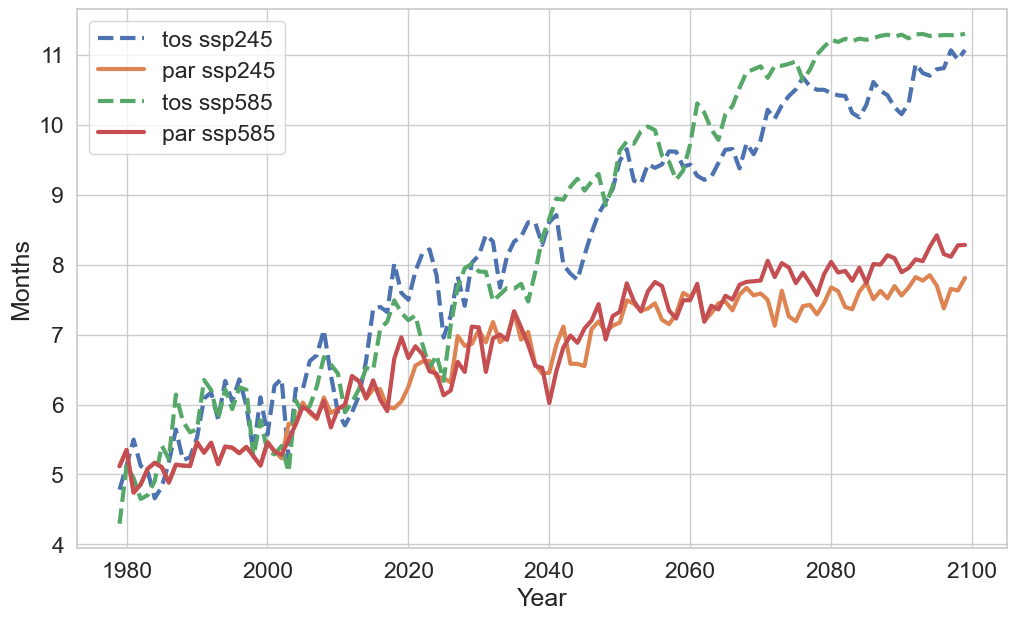

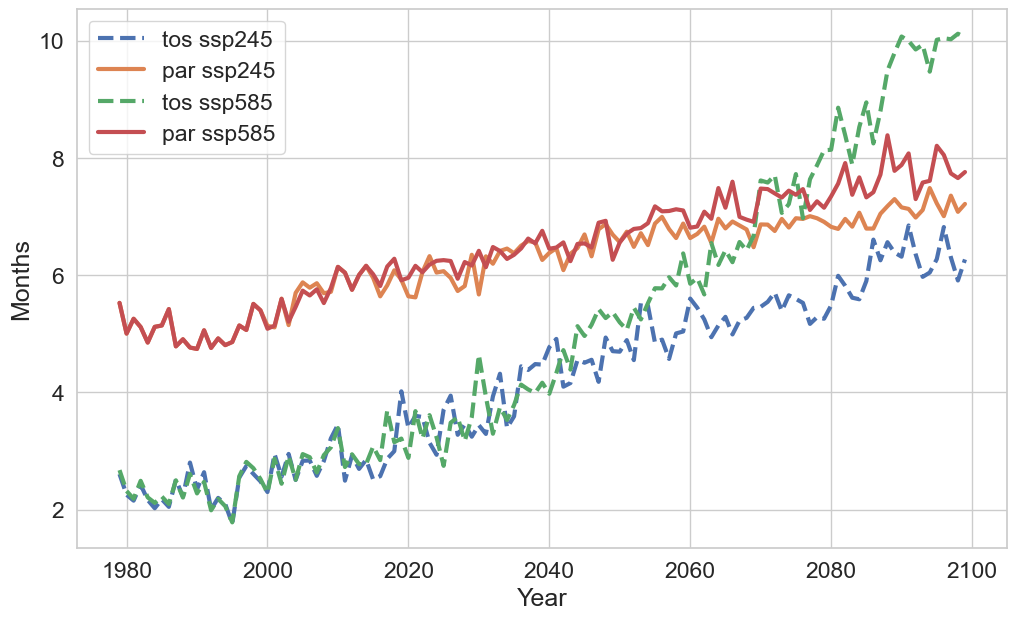

In [64]:
LMES = ['Barents Sea', 'Northern Bering - Chukchi Seas']
scenarios = ["ssp245", "ssp585"]

#LMES = ['Northern Bering - Chukchi Seas']
#scenarios = ["ssp245"]
light_threshold=1.0

for LME in LMES:
    ax_time=None
    timeseries=True
    for scenario in scenarios:
        ds = xr.open_dataset(f"Months_per_year_with_minimum_light_{LME}_{scenario}.nc")
        ds_tos = xr.open_dataset(f"Months_per_year_with_minimum_light_tos_{LME}_{scenario}.nc")

        ds_fix = xr.where(ds["par"]>light_threshold,1, 0)
        ds_fix = xr.where(ds_fix<-1,np.nan,ds_fix)

        ds_fix_tos = xr.where(ds_tos["tos_mean"]>0.0, 1, 0).sel(time=slice("1979","2100"))
        ds_fix_tos = xr.where(ds_fix_tos<-2,np.nan,ds_fix_tos)

        light_count = ds_fix  \
                .groupby('time.year') \
                .sum(dim='time')
        light_count = get_data_within_LME(light_count, LME)

        tos_count = ds_fix_tos \
                .groupby('time.year') \
                .sum(dim='time')
        tos_count = get_data_within_LME(tos_count, LME)

        ds=light_count.mean({"lat","lon"}, skipna=True)
        df=ds.to_dataframe()

        df["year"]=df.index
       # df = df.pivot('year','percentiles', 'par')
        df=df.drop(columns=['percentiles','year','spatial_ref'])

        if not timeseries:
            fig=plt.figure(figsize=(12,7))
            ax = sns.heatmap(df, annot = False)
            ax.invert_yaxis()
            ax.set(xlabel="Months of the year when minimum light is above 1Wm$^{2}$")

            plotfile=f"Figures/Months_per_year_with_minimum_tos_{LME}_{scenario}.png"
            if os.path.exists(plotfile): os.remove(plotfile)
            plt.savefig(plotfile)
          #  plt.show()

        ds=tos_count.mean({"lat","lon"}, skipna=True)

        df_tos=ds.to_dataframe()
        if not timeseries:
            fig=plt.figure(figsize=(12,7))

            df_tos["year"]=df_tos.index
            df_tos=df_tos.drop(columns=['spatial_ref','year'])

          #  df_tos = df_tos.pivot('year','spatial_ref','tos_mean')

            ax = sns.heatmap(df_tos, annot = False)
            ax.invert_yaxis()
            ax.set(xlabel="Months of the year when minimum temp is above 0$^{o}$C")

            plotfile=f"Figures/Months_per_year_with_minimum_tos_{LME}_{scenario}.png"
            if os.path.exists(plotfile): os.remove(plotfile)
            plt.savefig(plotfile)

        # Timeseries
        if timeseries:
            sns.set_style("whitegrid", {'legend.frameon':False})

            if ax_time is None:
                fig=plt.figure(figsize=(12,7))
                ax_time = sns.lineplot(x = "year", y = "tos_mean", data = df_tos, linewidth=3, label=f"tos {scenario}", linestyle='--')
            else:
                sns.lineplot(ax=ax_time, x = "year", y = "tos_mean", data = df_tos, linewidth=3, label=f"tos {scenario}", linestyle='--')
            sns.lineplot(ax=ax_time, x = "year", y = "par", data = df, linewidth=3, label=f"par {scenario}")

            if scenario=="ssp585":
                ax_time.set(xlabel="Year")
                ax_time.set(ylabel="Months")
                ax_time.legend()

                plotfile=f"Figures/Timeseries_months_per_year_with_minimum_tos_and_par_{LME}.png"
                if os.path.exists(plotfile): os.remove(plotfile)
                print(f"Saving to file {plotfile}")
                fig.savefig(plotfile,dpi=300)
              #  plt.show()
